# Class prior estimation methods

Cost-sensitive approaches crucially rely on the knowledge of outcome prior $\pi$, which might have a large impact on the quality of the recommendations. $y \in \{−1, 0, 1\}$ are the accessible labels. Let us denote $s \in \{−1, 1\}$ the true labels, and $v$ is the feature vector. Under the usual assumptions made in Positive-Unlabeled (PU) learning:
$$\pi := \mathbb{P}(s = 1)\;.$$

**benchscofi** provides implementations of several class prior estimation methods, shown below. We will test their performance on a randomly generated subset, resp. on real-life drug repurposing datasets.

In [2]:
from importlib import reload
import stanscofi.datasets
import stanscofi.utils
import numpy as np

import sys
sys.path.insert(0,"src/")

import benchscofi
import benchscofi.utils
from benchscofi.utils import prior_estimation

rseed=12345

## 1. Datasets

### 1.1 Randomly generated PU dataset, with exactly known true $\pi$

#####  Censoring setting

Assume that $s \in \{-1,1\}$ are the true labels, $y \in \{0,1\}$ are the accessible labels (note that accessible negative samples are missing), and $v \in \mathbb{R}^d$ are the feature vectors. Samples $(v,s) \sim p(v,s)$, and then are made accessible as follows $y \sim p(\cdot \mid v, s=1)$ and $\mathbb{P}(y \neq 0 \mid v, s=-1) = p(y=-1 \mid v, s=1) = 0$.

##### Case-Control setting

Assume that $s \in \{-1,1\}$ are the true labels, $y \in \{-1,0,1\}$ are the accessible labels, and $v \in \mathbb{R}^d$ are the feature vectors. Positive pairs $v \sim p_+ = p(\cdot | y=+1)$, negative pairs $v \sim p_- = p(\cdot | y=-1)$, and unlabeled pairs $v \sim p_u = \pi p_+ + (1-\pi)p_-$ (where $\pi := \mathbb{P}(s = 1) \in (0,1)$ is the class-prior probability).

##### SCAR assumption [1] (for the censoring setting)

$$c := \mathbb{P}(y \neq 0 | s=1) = \mathbb{P}(y \neq 0 | v, s=1) = \text{cst}\;.$$

##### Invariance of order [2] (for the case-control setting)

$$\forall v, v' \in \mathbb{R}^d, \ \mathbb{P}(s = 1 \mid v) \leq \mathbb{P}(s = 1 \mid v') \Leftrightarrow \mathbb{P}(y= 1 \mid v) \leq \mathbb{P}(y=1 \mid v')\;.$$

**[1]** Elkan, Charles, and Keith Noto. "Learning classifiers from only positive and unlabeled data." Proceedings of the 14th ACM SIGKDD international conference on Knowledge discovery and data mining. 2008.

**[2]** Kato, Masahiro, Takeshi Teshima, and Junya Honda. "Learning from positive and unlabeled data with a selection bias." International conference on learning representations. 2018.

In [3]:
import pandas as pd

def print_naive_estimators(dataset, labels_mat, true_args):
    pos_known = np.sum(dataset.ratings[:,2]>0)/dataset.ratings.shape[0]
    pos_total = np.sum(dataset.ratings_mat>0)/np.prod(dataset.ratings_mat.shape)
    known_total = np.sum(dataset.ratings_mat!=0)/np.prod(dataset.ratings_mat.shape)
    pos_unk = np.sum(dataset.ratings_mat>0)/np.sum(dataset.ratings_mat==0)
    neg_pos = np.sum(dataset.ratings_mat<0)/np.sum(dataset.ratings_mat>0)
    pos_known_true = np.nan if(labels_mat is None) else np.sum(labels_mat.values>0)/np.prod(labels_mat.values.shape)
    return pd.DataFrame(
        [
            [true_args[arg] for arg in true_args]
            +[pos_known, known_total, pos_unk, pos_known_true, 
              pos_total/true_args["pi"] if ("pi" in true_args) else np.nan, 
              pos_total/pos_known_true if (labels_mat is not None) else np.nan,
              neg_pos]
        ],
        columns=[arg for arg in true_args]+["#Pos/#Known", "#Known/#Total~sparsity", "#Pos/#Unk", 
                "#Pos/#Known(true)~pi", "#Pos/(#Total*pi)~c", "(#Pos/#Total)/(#Pos/#Known(true))~c", "#Neg/#Pos"],
        index=["Value"],
    )

synthetic_params = {
    "N":10000, "nfeatures":100, "mean":2, "std":0.1, "exact": True, "random_state": rseed,
}

#### 1.1.a  Censoring setting

Generate a synthetic dataset which matches the specifications of the censoring setting. In that setting, there are only positive ($y=1$) and unlabeled ($y=0$) samples (*i*.*e*., all negative samples are unlabeled). Note that
$$c \pi = \mathbb{P}(y=1 \mid s=1)\mathbb{P}(s=1) = \mathbb{P}(y=1)-\underbrace{\mathbb{P}(y=1 \mid s=-1)}_{=0}\mathbb{P}(s=-1)\;.$$

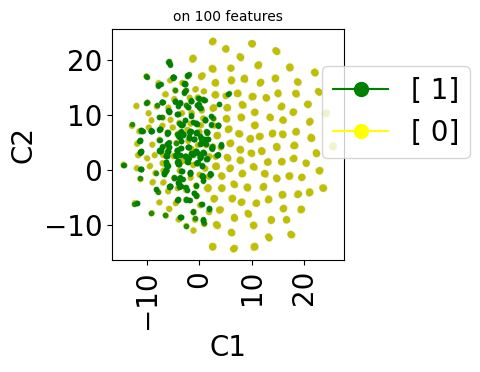

----------------------------------------------------------------------
* Matching matrix:
Ratings: 30 drugs	101 diseases involved in at least one known matching
606 positive, 0 negative, 9595 unknown matchings
Sparsity for drugs/diseases involved in at least one known matching: 5.94 perc.
-----------------------------------
* Feature matrices:
Total #Drugs: 101	#Drug features: 50	Perc. Missing features: 0
Total #Diseases: 101	#Disease features: 50	Perc. Missing features: 0
----------------------------------------------------------------------



,pi,c,#Pos/#Known,#Known/#Total~sparsity,#Pos/#Unk,#Pos/#Known(true)~pi,#Pos/(#Total*pi)~c,(#Pos/#Total)/(#Pos/#Known(true))~c,#Neg/#Pos
Value,0.3,0.2,1.0,0.059406,0.063158,0.29703,0.19802,0.2,0.0


In [4]:
from benchscofi.utils.prior_estimation import generate_Censoring_dataset

true_args_censoring = {"pi": 0.3, "c":0.2}
censoring_params = {}
censoring_params.update(true_args_censoring)
censoring_params.update(synthetic_params)

censoring_di, censoring_labels_mat = generate_Censoring_dataset(**censoring_params)
censoring_dt = stanscofi.datasets.Dataset(**censoring_di)
censoring_dt.visualize(withzeros=True, figsize=(3,3), dimred_args={"n_neighbors": 10})

censoring_dt.summary()

print_naive_estimators(censoring_dt, censoring_labels_mat, true_args_censoring)
## pi ~ #pos/#total in the true labels matrix which is OK
## c ~ (#pos/#total)/pi in the ratings matrix which is OK

#### 1.1.b  Case-Control setting

This setting allows negative samples to be accessible.

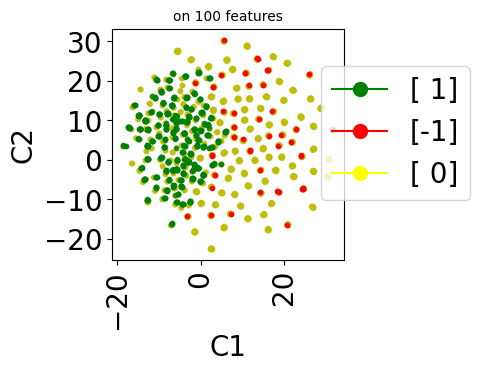

----------------------------------------------------------------------
* Matching matrix:
Ratings: 67 drugs	100 diseases involved in at least one known matching
952 positive, 47 negative, 9001 unknown matchings
Sparsity for drugs/diseases involved in at least one known matching: 9.99 perc.
-----------------------------------
* Feature matrices:
Total #Drugs: 100	#Drug features: 50	Perc. Missing features: 0
Total #Diseases: 100	#Disease features: 50	Perc. Missing features: 0
----------------------------------------------------------------------



,pi,imbalance,sparsity,#Pos/#Known,#Known/#Total~sparsity,#Pos/#Unk,#Pos/#Known(true)~pi,#Pos/(#Total*pi)~c,(#Pos/#Total)/(#Pos/#Known(true))~c,#Neg/#Pos
Value,0.3,0.05,0.1,0.952953,0.0999,0.105766,0.3,0.317333,0.317333,0.04937


In [5]:
reload(benchscofi.utils.prior_estimation)
from benchscofi.utils.prior_estimation import generate_CaseControl_dataset

true_args_casecontrol = {"pi": 0.3, "imbalance": 0.05, "sparsity": 0.1}
casecontrol_params = {}
casecontrol_params.update(true_args_casecontrol)
casecontrol_params.update(synthetic_params)

casecontrol_di, casecontrol_labels_mat = generate_CaseControl_dataset(**casecontrol_params)
casecontrol_di.update({"name": "casecontrol"})
casecontrol_dt = stanscofi.datasets.Dataset(**casecontrol_di)
casecontrol_dt.visualize(withzeros=True, figsize=(3,3), dimred_args={"n_neighbors": 10})

casecontrol_dt.summary()

print_naive_estimators(casecontrol_dt, casecontrol_labels_mat, true_args_casecontrol)
## pi ~ #pos/#total in the true labels matrix which is OK
## sparsity ~ #known/#total in the ratings matrix which is OK

### 1.2 Real-life drug repurposing dataset (unknown $\pi$)

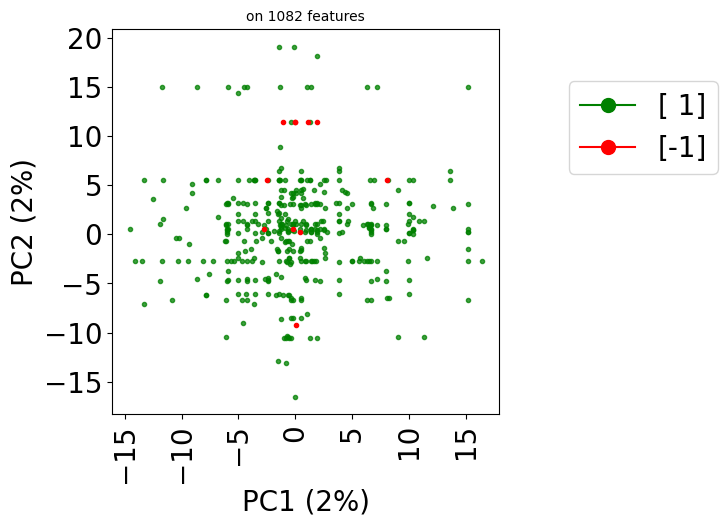

,#Pos/#Known,#Known/#Total~sparsity,#Pos/#Unk,#Pos/#Known(true)~pi,#Pos/(#Total*pi)~c,(#Pos/#Total)/(#Pos/#Known(true))~c,#Neg/#Pos
Value,0.973301,0.004451,0.004352,NaN,NaN,NaN,0.027431


In [6]:
dataset_name="TRANSCRIPT"
dataset_folder="datasets/"

data_args = stanscofi.utils.load_dataset(dataset_name, dataset_folder)
real_dataset = stanscofi.datasets.Dataset(**data_args)

real_dataset.visualize(withzeros=False)
print_naive_estimators(real_dataset, None, {})

## 2. Class prior estimation methods relying on a pretrained classifier

### 2.1 Train a classifier

We also generate a validation dataset which is produced in the same fashion as the training dataset.

In [8]:
from stanscofi.validation import compute_metrics, plot_metrics
from stanscofi.preprocessing import preprocessing_routine
#from stanscofi.training_testing import traintest_validation_split
from sklearn.model_selection import cross_validate ## works when no PU learning...
from sklearn.model_selection import StratifiedKFold ## otherwise we end up with single-class batches
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from copy import deepcopy

from stanscofi.models import create_scores
from sklearn.svm import SVC ## SVM alone dies on PU learning (as expected)
#from benchscofi.PulearnWrapper import PulearnWrapper
from pulearn import ElkanotoPuClassifier ## let's be conservative and directly use the implementation in pulearn
import random

def train_classifier(dataset, test_size=0.2, show_plots=False):
    np.random.seed(rseed)
    random.seed(rseed)
    ## Model parameters: basic SVM
    #model = SVC(C=5., kernel='rbf', gamma=0.5, probability=True, random_state=rseed)
    ## Model parameters: PU learn
    model = ElkanotoPuClassifier(**{
                "estimator": SVC(C=5., kernel='rbf', gamma=0.4, probability=True),
                "hold_out_ratio": 0.2,
            })
    
    ## Random split
    X, y, _,_,_ = preprocessing_routine(dataset, "meanimputation_standardize")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                            random_state=rseed, shuffle=True, stratify=y)
    
    ## Preprocessing and fitting on the training set
    y_train[y_train<1] = -1 ## /!\ unlabeled samples are -1 in pulearn
    y_test[y_test<1] = -1 ## /!\ unlabeled samples are -1 in pulearn
    
    #model.fit(X_train,y_train) ## it overfits (as expected)
    #sc = roc_auc_score(y_train, model.predict_proba(X_train), average="weighted", multi_class="ovr")
    #print("AUC (full test during training): %f" % sc)
    
    ## K-fold Cross-validation (to avoid overfitting)
    ## Write equivalent to cross_validate
    scores = {'test_score': [], 'estimator': []}
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rseed) ## to avoid issues with AUC
    for train_index, test_index in skf.split(X_train, y_train):
        scores['estimator'].append(deepcopy(model))
        scores['estimator'][-1].fit(X_train[train_index,:], y_train[train_index])
        scores['test_score'].append(
            roc_auc_score(
                y_train[test_index], 
                scores['estimator'][-1].predict_proba(X_train[test_index,:]).ravel(),
                average="weighted",
                multi_class="ovr"
            )
        )
        print("Fold %d test score = %f" % (len(scores['test_score']), scores['test_score'][-1]))
    model = scores["estimator"][np.argmax(scores['test_score'])]
    print("AUC (full test during training): %f" % np.max(scores['test_score']))
    
    return model, X_train, y_train, X_test, y_test

### 2.2 Estimators from the literature

**In the censoring setting**: Three estimators $e_1$, $e_2$ and $e_3$ of $c := \mathbb{P}(s=1 \mid y \neq 0)$ proposed by **[1]**. Given a trained classifier $\widehat{\theta}$, and a validation set $\mathcal{V} := \{ (v,y) \mid y \in \{-1,0,1\}, v \in \mathbb{R}^d \}$,
$$ e_1 := \frac{1}{|\{v \mid (v,+1) \in \mathcal{V}\}|}\sum_{(v,+1) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+\;;  e_2 := \frac{\sum_{(v',+1) \in \mathcal{V}} (f_{\widehat{\theta}}(v'))_+}{\sum_{(v,y) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+}\;; e_3 := \max_{(v,y) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+\;. $$

If $f_{\widehat{\theta}}(v)=\mathbb{P}(s=1 | v)$ for any $v$, then $e_1=c$. It is assumed that $e_3 \leq c$. Authors recommend using $e_1$. But that approach requires having access to a supplementary validation dataset with labelled samples. One can retrieve an approximation of $\pi:=\mathbb{P}(s=1)$ by using $c\pi = \mathbb{P}(y=1) \approx \sum_{(v',+1) \in \mathcal{V}} (f_{\widehat{\theta}}(v'))_+$
$$\hat{\pi}_i := \frac{e_i^{-1}}{|\mathcal{V}|}\sum_{(v,+1) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+\;.$$

**[1]** Charles Elkan and Keith Noto. Learning classifiers from only positive and unlabeled data. In Proceedings of the 14th ACM SIGKDD international conference on Knowledge discovery and data mining, pages 213–220, 2008.

In [351]:
model, X_train, y_train, X_test, y_test = train_classifier(censoring_dt, test_size=0.2)

Fold 1 test score = 0.669297
Fold 2 test score = 0.637859
Fold 3 test score = 0.713362
Fold 4 test score = 0.604654
Fold 5 test score = 0.631344
AUC (full test during training): 0.713362


In [352]:
## test performance (to check for overfitting)
auc = roc_auc_score(y_test, model.predict_proba(X_test), average="weighted", multi_class="ovr")
print("AUC (full validation): %f" % auc)

AUC (full validation): 0.729020


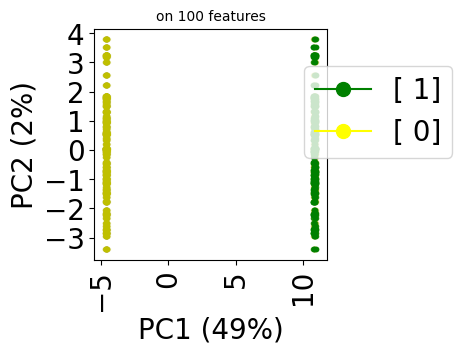

In [12]:
censoring_dt.visualize(withzeros=True, figsize=(3,3)) # we expect that for SVM it should be a hard instance
## however, PU methods should be OK, as unlabeled negatives are clearly different from (un)labeled positives

In [354]:
## Obtained with predict_proba in pulearn, but do not belong to [0,1]...
print([f(model.predict_proba(X_test)) for f in [np.min, np.mean, np.max]])

c = model.c ## = P(y=1|s=1) computed on hold-out datapoints
proba_test = model.estimator.predict_proba(X_test)[:,1] ## = P(y=1|x) class 1 
## (assuming that the given labels y are the true labels s in a non PU learning setting)
proba_test_pu = proba_test/c ## =P(s=1|x)=P(y=1|x)/c (Lemma 1 in the paper [Elkan et Noto, 2008])
[f(proba_test_pu) for f in [np.min, np.mean, np.max]] ## l. 247 predict_proba

[0.4205086367362786, 0.8805847482918375, 6.066017859392971]


[0.4205086367362786, 0.8805847482918375, 6.066017859392971]

In [375]:
from benchscofi.utils import prior_estimation
reload(prior_estimation)

pred_scores=(y_test>=1).astype(int) ## perfect classifier on the unlabeled testing set 
## (expect c=1 as no unlabeled are assumed)

pred_scores=model.predict_proba(X_test) ## using the trained PU classifier (not perfect)
pred_scores[pred_scores<0] = 0
pred_scores[pred_scores>1] = 1
## might be more or less c and pi

## perfect PU classifier on the testing set
#dt = deepcopy(censoring_dt)
#dt.ratings_mat = censoring_labels_mat.values
#X, ytrue, _,_,_ = preprocessing_routine(dt, "meanimputation_standardize")
#_, _, _, pred_scores = train_test_split(X, ytrue, test_size=0.2, 
#                            random_state=rseed, shuffle=True, stratify=y)
#pred_scores=(pred_scores>=1).astype(int)
## we expect to retrieve c and pi

[e1,pi1], [e2,pi2], [e3,pi3] = [
    prior_estimation.data_aided_estimation(pred_scores, y_test, estimator_type=i) 
    for i in [1,2,3]
 ]

print("Hold-out c = %f" % model.c)
pd.DataFrame(
    [
        [e1, e2, e3, pi1, pi2, pi3],
        [true_args_censoring["c"]]*3+[true_args_censoring["pi"]]*3,
    ]
, index=["Estimated", "True"], columns=["e1", "e2", "e3", "pi1", "pi2", "pi3"])

Hold-out c = 0.065190


,e1,e2,e3,pi1,pi2,pi3
Estimated,0.89126,0.065111,1.0,0.059285,0.811509,0.052838
True,0.20000,0.200000,0.2,0.300000,0.300000,0.300000


Surprisingly enough, when providing a perfect PU classifier, the corresponding estimator (type $2$) for $\pi$ is not too bad (see below), *i*.*e*.,
$$\hat{\pi}_2 := \frac{1}{|\mathcal{V}|}\sum_{(v,y) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+ \approx \mathbb{E}_{(v,y) \sim p}[y]\;.$$
The other estimators are super bad though... Let us test this estimator on the real-life dataset:

## 3. Class prior estimation methods with Bayes regret approach

**In the case-control setting:**  **[1, Theorem $4$]** shows that if the supports for $p_+$ and $p_-$ are different
$$\hat{\pi} = -\lim_{\substack{\alpha \rightarrow 1\\ \alpha < 1}}\frac{\partial}{\partial \alpha}\inf_{\theta \in \Theta} \left\{  \underbrace{\mathcal{R}_\text{0-1}(\theta)}_\text{Bayes regret} \mid \mathbb{E}_{v \sim p_-}\ell_{0-1}(C_\theta(v),-1) \leq \alpha \right\}(\alpha)\;.$$

The issue is that the equation shown above can't be computed exactly in practice. As mentioned in **[2]**, a possible approach to approximate $\hat{\pi}$ is to regress a specific model (given in **[2]**) on the points of the corresponding ROC curve, and use the fitted model to extract the slope at the right-hand side of the curve, which is $\hat{\pi}$.

**[1]** Scott, Clayton, and Gilles Blanchard. "Novelty detection: Unlabeled data definitely help." Artificial intelligence and statistics. PMLR, 2009.

**[2]** Sanderson, Tyler, and Clayton Scott. "Class proportion estimation with application to multiclass anomaly rejection." Artificial Intelligence and Statistics. PMLR, 2014.

In [10]:
model, X_train, y_train, X_test, y_test = train_classifier(casecontrol_dt, test_size=0.2)
## test performance (to check for overfitting)
auc = roc_auc_score(y_test, model.predict_proba(X_test), average="weighted", multi_class="ovr")
print("AUC (full validation): %f" % auc)

Fold 1 test score = 0.822278
Fold 2 test score = 0.788519
Fold 3 test score = 0.788620
Fold 4 test score = 0.812863
Fold 5 test score = 0.789474
AUC (full test during training): 0.822278
AUC (full validation): 0.793568


In [11]:
## Obtained with predict_proba in pulearn, but do not belong to [0,1]...
print([f(model.predict_proba(X_test)) for f in [np.min, np.mean, np.max]])

c = model.c ## = P(y=1|s=1) computed on hold-out datapoints
proba_test = model.estimator.predict_proba(X_test)[:,1] ## = P(y=1|x) class 1 
## (assuming that the given labels y are the true labels s in a non PU learning setting)
proba_test_pu = proba_test/c ## =P(s=1|x)=P(y=1|x)/c (Lemma 1 in the paper [Elkan et Noto, 2008])
[f(proba_test_pu) for f in [np.min, np.mean, np.max]] ## l. 247 predict_proba

[0.3486322429787321, 0.6497713324513608, 5.4664028758471055]


[0.3486322429787321, 0.6497713324513608, 5.4664028758471055]

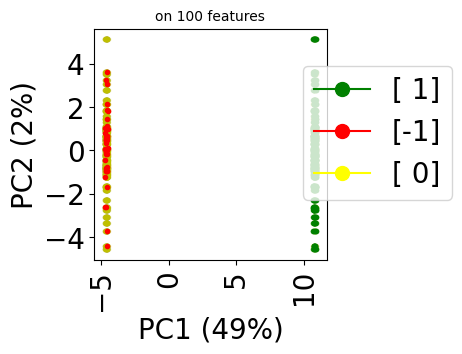

In [13]:
casecontrol_dt.visualize(withzeros=True, figsize=(3,3)) # we expect that for SVM it should be a hard instance
## however, PU methods should be OK, as unlabeled negatives are clearly different from (un)labeled positives

In [58]:
from benchscofi.utils import prior_estimation
reload(prior_estimation)

pred_scores=model.predict_proba(X_test) ## using the trained PU classifier (not perfect)
## might be more or less pi

pi_star1, pi_star2 = [
    prior_estimation.roc_aided_estimation(pred_scores, y_test, regression_type=i) for i in [1,2]
]

pd.DataFrame(
    [
        [pi_star1, pi_star2],
        [true_args_censoring["pi"]]*2,
    ]
, index=["Estimated", "True"], columns=["pi*1", "pi*2"])

Optimization terminated successfully.
         Current function value: 91.901074
         Iterations: 76
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 92.962294
         Iterations: 882
         Function evaluations: 1609


,pi*1,pi*2
Estimated,0.286561,0.259399
True,0.300000,0.300000


Even if the PU classifier is not perfect, estimator $\hat{\pi}_1$ (see PDF) achieves reasonable performance.

Fold 1 test score = 0.998613
Fold 2 test score = 0.996364
Fold 3 test score = 0.998514
Fold 4 test score = 0.997351
Fold 5 test score = 0.997833
AUC (full test during training): 0.998613
Optimization terminated successfully.
         Current function value: 3.187855
         Iterations: 169
         Function evaluations: 342
Optimization terminated successfully.
         Current function value: 110.944144
         Iterations: 159
         Function evaluations: 305
Test 1, pi=0.100000, pi_hat=-0.000000 pi_hat2=-0.000863
Fold 1 test score = 0.921033
Fold 2 test score = 0.901965
Fold 3 test score = 0.929633
Fold 4 test score = 0.927936
Fold 5 test score = 0.944708
AUC (full test during training): 0.944708
Optimization terminated successfully.
         Current function value: 49.149679
         Iterations: 77
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 52.985065
         Iterations: 994
         Function evaluations: 1804
Test 2

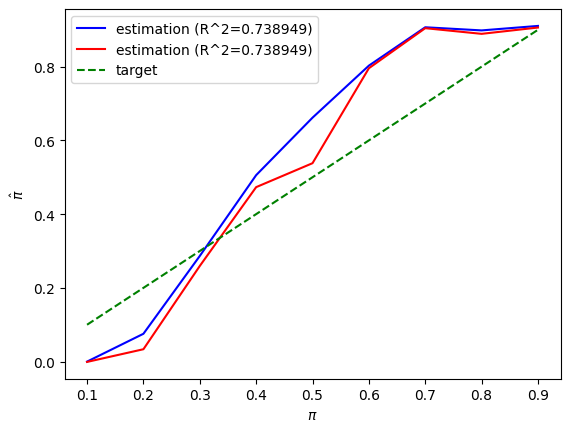

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

## One could also have more precise estimates by iterating on several random seeds (here we always consider rseed)
def test_estimator(pi_true):
    pi_hats, pi_hats2 = [], []
    for i, pi_t in enumerate(pi_true):
        casecontrol_params_pi = {}
        casecontrol_params_pi.update(true_args_casecontrol)
        casecontrol_params_pi.update(synthetic_params)
        casecontrol_params_pi.update({'pi': pi_t})
        data_args_pi, labels = generate_CaseControl_dataset(**casecontrol_params_pi)
        casecontrol_dt_pi = stanscofi.datasets.Dataset(**data_args_pi)
        #print(print_naive_estimators(casecontrol_dt_pi, labels, casecontrol_params_pi))
        model_pi, _, _, X_test_pi, y_test_pi = train_classifier(casecontrol_dt_pi, test_size=0.2)
        pred_scores_pi=model_pi.predict_proba(X_test_pi)
        pi_hat = prior_estimation.roc_aided_estimation(pred_scores_pi, y_test_pi, regression_type=1)
        pi_hat2 = prior_estimation.roc_aided_estimation(pred_scores_pi, y_test_pi, regression_type=2)
        pi_hats.append(pi_hat)
        pi_hats2.append(pi_hat2)
        print("Test %d, pi=%f, pi_hat=%f pi_hat2=%f" % (i+1, pi_t, pi_hat, pi_hat2))
    R = r2_score(pi_true, pi_hats)
    plt.plot(pi_true, pi_hats, "b-", label="estimation (R^2=%f)" % R)
    R2 = r2_score(pi_true, pi_hats2)
    plt.plot(pi_true, pi_hats2, "r-", label="estimation (R^2=%f)" % R2)
    plt.plot(pi_true, pi_true, "g--", label="target")
    plt.xlabel(r"$\pi$")
    plt.ylabel(r"$\hat{\pi}$")
    plt.legend()
    plt.show()
    
test_estimator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

## 4. Class prior estimation methods through penalized divergences

TODO penalized divergences

In [70]:
print_naive_estimators(casecontrol_dt, casecontrol_labels_mat, true_args_casecontrol)

,pi,imbalance,sparsity,#Pos/#Known,#Known/#Total~sparsity,#Pos/#Unk,#Pos/#Known(true)~pi,#Pos/(#Total*pi)~c,(#Pos/#Total)/(#Pos/#Known(true))~c,#Neg/#Pos
Value,0.3,0.05,0.1,0.952953,0.0999,0.105766,0.3,0.317333,0.317333,0.04937


In [69]:
model, X_train, y_train, X_test, y_test = train_classifier(casecontrol_dt, test_size=0.2)
## test performance (to check for overfitting)
auc = roc_auc_score(y_test, model.predict_proba(X_test), average="weighted", multi_class="ovr")
print("AUC (full validation): %f" % auc)

Fold 1 test score = 0.822278
Fold 2 test score = 0.788519
Fold 3 test score = 0.788620
Fold 4 test score = 0.812863
Fold 5 test score = 0.789474
AUC (full test during training): 0.822278
AUC (full validation): 0.793568


In [32]:
## TODO

pred_scores=model.predict_proba(X_test) ## using the trained PU classifier (not perfect)
## might be more or less pi

pi_l1, pi_pearson = [
    prior_estimation.divergence_aided_estimation(synthetic_dataset_val, "meanimputation_standardize", lmb=1., 
                    sigma=1., divergence_type=div) for div in ["L1-distance","Pearson"]
]
pi_hat 

pd.DataFrame(
    [
        [pi_star1, pi_star2],
        [true_args_censoring["pi"]]*2,
    ]
, index=["Estimated", "True"], columns=["pi*1", "pi*2"])

ValueError: shapes (2,) and (21,) not aligned: 2 (dim 0) != 21 (dim 0)